In [36]:
import time
import math
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import data_structs
import re
import string
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import numpy as np
from sklearn import metrics
import csv
import pandas as pd


#data processing
class ProDataset(Dataset):
    """ Diabetes dataset."""

    # Initialize your data, download, etc.
    def __init__(self, is_train_set=False):
        filename = './data/npscore-train.csv' if is_train_set else './data/npscore-test.csv'
        with open(filename, "rt") as f:
            reader = csv.reader(f)
            rows = list(reader)
        
        self.lines = [row[0] for row in rows]
        self.properties = [row[1] for row in rows]
        self.len = len(self.properties)

        self.property_list = list(sorted(set(self.properties)))

    def __getitem__(self, index):
        return self.lines[index], self.properties[index]

    def __len__(self):
        return self.len

    def get_properties(self):
        return self.property_list

    def get_property(self, id):

        return self.property_list[id]

    def get_property_id(self, property):
        return self.property_list.index(property)



# Voc loaders
with open('./data/Voc-np', 'r') as f:
    chars = f.read().split()
print(chars)
all_letters = chars
N_CHARS = len(all_letters)

# Parameters and DataLoaders
HIDDEN_SIZE = 128
N_LAYERS = 2
BATCH_SIZE = 256 #should be changed
N_EPOCHS = 30


test_dataset = ProDataset(is_train_set=False)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE, shuffle=True)


train_dataset = ProDataset(is_train_set=True)
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE, shuffle=True)

print(len(train_loader.dataset))
print(len(test_loader.dataset))

N_PROPERTIES = len(train_dataset.get_properties())
print(N_PROPERTIES, "properties")

['3', '7', 'o', '[N]', '[NH3+]', '\\', '9', '[N@@+]', 'r', 'l', '[O+]', '[s@]', '[NH-]', ')', 'P', '[S-]', '2', '/', '(', '6', '[C-]', '[nH+]', '[O-]', '[C@@]', '[C@]', '[o+]', '[CH-]', '[c-]', '[O]', '1', '[S@@]', '[P@@H]', '[c+]', '%', 'I', 'L', 'R', '=', '[C]', '[NH+]', '8', '[N@+]', '[P@]', '[CH]', 'O', '[C+]', '0', '[s+]', 's', '[C@@H]', '[Si]', '[CH+]', '[P+]', 'S', '[N-]', 'C', '[NH2+]', '[S@]', '5', 'c', '[n-]', '[OH+]', '[C@H]', 'F', '[nH]', '[P@@]', '[n+]', '[P@H]', '[N+]', 'B', '[cH-]', '#', 'N', '4', '[CH2-]', 'n', '[S+]']
74759
18691
2 properties


In [37]:

# Some utility functions
def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def create_variable(tensor):
    # Do cuda() before wrapping with variable
    if torch.cuda.is_available():
        return Variable(tensor.cuda())
    else:
        return Variable(tensor)


In [38]:
# pad sequences and sort the tensor
def pad_sequences(vectorized_seqs, seq_lengths, properties):
    seq_tensor = torch.zeros((len(vectorized_seqs), seq_lengths.max())).long()
    for idx, (seq, seq_len) in enumerate(zip(vectorized_seqs, seq_lengths)):
        seq_tensor[idx, :seq_len] = torch.LongTensor(seq)

    # Sort tensors by their length
    seq_lengths, perm_idx = seq_lengths.sort(0, descending=True)
    seq_tensor = seq_tensor[perm_idx]

    # Also sort the target (countries) in the same order
    target = properties2tensor(properties)
    if len(properties):
        target = target[perm_idx]

    # Return variables
    # DataParallel requires everything to be a Variable
    return create_variable(seq_tensor), \
        create_variable(seq_lengths), \
        create_variable(target)

In [39]:
# Create necessary variables, lengths, and target
def make_variables(lines, properties):
    sequence_and_length = [line2voc_arr(line) for line in lines]
    vectorized_seqs = [sl[0] for sl in sequence_and_length]
    seq_lengths = torch.LongTensor([sl[1] for sl in sequence_and_length])
    return pad_sequences(vectorized_seqs, seq_lengths, properties)

#used to put char into acsii index,ord() will return the index of ascii ie. ord(c) =99
def str2ascii_arr(msg):
    arr = [ord(c) for c in msg]
    return arr, len(arr)

def letterToIndex(letter):
    return all_letters.index(letter)
print(letterToIndex('c'))

def line2voc_arr(line):
    arr = []
    regex = '(\[[^\[\]]{1,10}\])'
    line = data_structs.replace_halogen(line)
    char_list = re.split(regex, line)
    for li, char in enumerate(char_list):
        if char.startswith('['):
               arr.append(letterToIndex(char)) 
        else:
            chars = [unit for unit in char]

            for i, unit in enumerate(chars):
                arr.append(letterToIndex(unit))
    return arr, len(arr)

#print(make_variables('C1ccccC1',0))

def properties2tensor(properties):
    property_ids = [train_dataset.get_property_id(
        property) for property in properties]
    return torch.LongTensor(property_ids)

59


In [40]:
class RNNClassifier(nn.Module):
    # Our model

    def __init__(self, input_size, hidden_size, output_size, n_layers=1, bidirectional=True):
        super(RNNClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_directions = int(bidirectional) + 1

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers,dropout = 0.2,
                          bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input, seq_lengths):
        # Note: we run this all at once (over the whole input sequence)
        # input shape: B x S (input size)
        # transpose to make S(sequence) x B (batch)
        input = input.t()
        batch_size = input.size(1)

        # Make a hidden
        hidden = self._init_hidden(batch_size)

        # Embedding S x B -> S x B x I (embedding size)
        embedded = self.embedding(input)

        # Pack them up nicely
        gru_input = pack_padded_sequence(
            embedded, seq_lengths.data.cpu().numpy())

        # To compact weights again call flatten_parameters().
        self.gru.flatten_parameters()
        output, hidden = self.gru(gru_input, hidden)
        #print(hidden)
        # Use the last layer output as FC's input
        # No need to unpack, since we are going to use hidden
        fc_output = self.fc(hidden[-1])
        return fc_output

    def _init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers * self.n_directions,
                             batch_size, self.hidden_size)
        return create_variable(hidden)
    

classifier = RNNClassifier(N_CHARS, HIDDEN_SIZE, N_PROPERTIES, 1)
print(classifier)
classifier.cuda()
input, seq_lengths, target = make_variables(["NC(=O)CC(NC(=O)c1ccco1)C(=O)O"],['NP'])
output= classifier(input,seq_lengths)
print(output)
output = output.data.max(1, keepdim = True)[1]
print(output)

RNNClassifier(
  (embedding): Embedding(77, 128)
  (gru): GRU(128, 128, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
tensor([[-0.3210,  0.0787]], device='cuda:0')
tensor([[ 1]], device='cuda:0')


/data0/zhengsj/anaconda3/lib/python3.6/site-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [41]:
# Train cycle
def train():
    total_loss = 0
    
    correct = 0
    train_data_size = len(train_loader.dataset)
    print(train_data_size)
    
    for i,(lines, properties) in enumerate (train_loader, 1):
        input, seq_lengths, target = make_variables(lines, properties)
        #print(seq_lengths)
        output = classifier(input, seq_lengths)
        #print(output)
        loss = criterion(output, target)
        total_loss += loss.data[0]

        classifier.zero_grad()
        loss.backward()
        optimizer.step()
        
        pred = output.data.max(1, keepdim = True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum() #view_as 转化成像pred一样的size
        #print('pred.size= ',pred.size())
        #print(target.data.view_as(pred).size())
        if i % 10 == 0:
            print('[{}] Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.2f}'.format(
                time_since(start), epoch,  i *
                len(lines), len(train_loader.dataset),
                100. * i * len(lines) / len(train_loader.dataset),
                total_loss / i * len(lines)))

    print('\nTrain set: Accuracy: {}/{} ({:.0f}%) '.format(
        correct, train_data_size, 100. * correct / train_data_size))   
#     print('output.data = ',output.data.size())
#     print('target.data = ',target.data.size())
#     print('pred.size= ',pred.size())
#     print(target.data.view_as(pred).size())    
    return total_loss
    


In [44]:
 #Testing cycle
def test(line=None):
    # Predict for a given name
    if line:
        input, seq_lengths, target = make_variables([line], [])
        output = classifier(input, seq_lengths)
        pred = output.data.max(1, keepdim=True)[1]
        property_id = pred.cpu().numpy()[0][0]
        print(line, "is", train_dataset.get_property(property_id))
        return

    print("evaluating trained model ...")
    correct = 0
    train_data_size = len(test_loader.dataset)
    totalpred = 0
    recall = 0
    postive_pred = np.array([0])
    all_target = np.array([0])
    AUC = 0
    for i,(lines, properties) in enumerate (test_loader, 1):
        input, seq_lengths, target = make_variables(lines, properties)
        #print(seq_lengths)
        output = classifier(input, seq_lengths)
        pred = output.data.max(1, keepdim = True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        totalpred = totalpred + pred.sum()
        recall += metrics.recall_score(target.data.view_as(pred), pred)
        #pred = output.data.max(1, keepdim=True)[1]
        pos = output[:,0]  #get the stable        
        postive_pred=np.concatenate((postive_pred,pos.data.cpu().numpy()),axis = 0)
        all_target=np.concatenate((all_target,target.data.cpu().numpy()),axis = 0)

        #if pred :
        #   total_pred = total_pred+1
        

        
#         fpr, tpr, thresholds = metrics.roc_curve(target.data.cpu().numpy(), pos.data.cpu().numpy(), pos_label=0)
#         AUC = metrics.auc(fpr, tpr)
#         print(AUC)
        

        #recall = metrics.recall_score(target.data.view_as(pred), pred)
        #roc_score = roc

    fpr, tpr, thresholds = metrics.roc_curve(all_target, postive_pred, pos_label=0)
    AUC = metrics.auc(fpr, tpr)
    print('AUC = ',AUC)
    print('\nTest set: Accuracy: {}/{} ({:.0f}%) Recall: ({:.0f}%)\n'.format(
        correct, train_data_size, 100. * correct / train_data_size,100. * recall / train_data_size*64))
    
    return 100. * correct / train_data_size

In [45]:
classifier = RNNClassifier(N_CHARS, HIDDEN_SIZE, N_PROPERTIES, N_LAYERS)
# if torch.cuda.device_count() > 1:
#     print("Let's use", torch.cuda.device_count(), "GPUs!")
#     # dim = 0 [33, xxx] -> [11, ...], [11, ...], [11, ...] on 3 GPUs
#     classifier = nn.DataParallel(classifier)

if torch.cuda.is_available():
    classifier.cuda()

optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

start = time.time()

print("Training for %d epochs..." % N_EPOCHS)

all_losses = []
all_accuracy = []
for epoch in range(1, N_EPOCHS + 1):
    # Train cycle
    all_losses.append(train())
    # Testing
    all_accuracy.append(test())
    

    # Testing several samples
    test("C1ccccC1")
    test("NC(=O)CC(NC(=O)c1ccco1)C(=O)O")
    test("Cc1ccccc1N1CC(C)C(=O)NC1=S")
    test("COC(=O)c1c[nH]c2nnsc12")


Training for 30 epochs...
74759


/data0/zhengsj/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  from ipykernel import kernelapp as app


 0s] Train Epoch: 1 [2560/74759 (3%)]	Loss: 177.26
 1s] Train Epoch: 1 [5120/74759 (7%)]	Loss: 173.04
 2s] Train Epoch: 1 [7680/74759 (10%)]	Loss: 170.91
 3s] Train Epoch: 1 [10240/74759 (14%)]	Loss: 168.56
 4s] Train Epoch: 1 [12800/74759 (17%)]	Loss: 165.43
 5s] Train Epoch: 1 [15360/74759 (21%)]	Loss: 161.61
 6s] Train Epoch: 1 [17920/74759 (24%)]	Loss: 157.43
 7s] Train Epoch: 1 [20480/74759 (27%)]	Loss: 153.50
 8s] Train Epoch: 1 [23040/74759 (31%)]	Loss: 149.02
 9s] Train Epoch: 1 [25600/74759 (34%)]	Loss: 144.92
 9s] Train Epoch: 1 [28160/74759 (38%)]	Loss: 141.02
 10s] Train Epoch: 1 [30720/74759 (41%)]	Loss: 137.89
 11s] Train Epoch: 1 [33280/74759 (45%)]	Loss: 135.20
 12s] Train Epoch: 1 [35840/74759 (48%)]	Loss: 132.60
 13s] Train Epoch: 1 [38400/74759 (51%)]	Loss: 130.22
 14s] Train Epoch: 1 [40960/74759 (55%)]	Loss: 128.23
 15s] Train Epoch: 1 [43520/74759 (58%)]	Loss: 126.30
 16s] Train Epoch: 1 [46080/74759 (62%)]	Loss: 124.44
 17s] Train Epoch: 1 [48640/74759 (65%)]	Los

 4s] Train Epoch: 5 [33280/74759 (45%)]	Loss: 56.85
 5s] Train Epoch: 5 [35840/74759 (48%)]	Loss: 56.74
 6s] Train Epoch: 5 [38400/74759 (51%)]	Loss: 56.85
 7s] Train Epoch: 5 [40960/74759 (55%)]	Loss: 57.00
 8s] Train Epoch: 5 [43520/74759 (58%)]	Loss: 56.71
 9s] Train Epoch: 5 [46080/74759 (62%)]	Loss: 56.60
 10s] Train Epoch: 5 [48640/74759 (65%)]	Loss: 56.62
 11s] Train Epoch: 5 [51200/74759 (68%)]	Loss: 56.71
 11s] Train Epoch: 5 [53760/74759 (72%)]	Loss: 56.74
 12s] Train Epoch: 5 [56320/74759 (75%)]	Loss: 56.77
 13s] Train Epoch: 5 [58880/74759 (79%)]	Loss: 56.77
 14s] Train Epoch: 5 [61440/74759 (82%)]	Loss: 56.65
 15s] Train Epoch: 5 [64000/74759 (86%)]	Loss: 56.74
 15s] Train Epoch: 5 [66560/74759 (89%)]	Loss: 56.64
 16s] Train Epoch: 5 [69120/74759 (92%)]	Loss: 56.74
 17s] Train Epoch: 5 [71680/74759 (96%)]	Loss: 56.67
 18s] Train Epoch: 5 [74240/74759 (99%)]	Loss: 56.64

Train set: Accuracy: 67066/74759 (89%) 
evaluating trained model ...
AUC =  0.9658269559499145

Test set

 8s] Train Epoch: 9 [64000/74759 (86%)]	Loss: 46.09
 8s] Train Epoch: 9 [66560/74759 (89%)]	Loss: 46.05
 9s] Train Epoch: 9 [69120/74759 (92%)]	Loss: 45.98
 10s] Train Epoch: 9 [71680/74759 (96%)]	Loss: 45.90
 11s] Train Epoch: 9 [74240/74759 (99%)]	Loss: 45.89

Train set: Accuracy: 68432/74759 (91%) 
evaluating trained model ...


/data0/zhengsj/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


AUC =  0.9685861732761912

Test set: Accuracy: 16702/18691 (89%) Recall: (22%)

C1ccccC1 is SM
NC(=O)CC(NC(=O)c1ccco1)C(=O)O is NP
Cc1ccccc1N1CC(C)C(=O)NC1=S is SM
COC(=O)c1c[nH]c2nnsc12 is SM
74759
 15s] Train Epoch: 10 [2560/74759 (3%)]	Loss: 53.97
 16s] Train Epoch: 10 [5120/74759 (7%)]	Loss: 50.25
 17s] Train Epoch: 10 [7680/74759 (10%)]	Loss: 49.44
 17s] Train Epoch: 10 [10240/74759 (14%)]	Loss: 48.03
 18s] Train Epoch: 10 [12800/74759 (17%)]	Loss: 47.24
 19s] Train Epoch: 10 [15360/74759 (21%)]	Loss: 47.43
 20s] Train Epoch: 10 [17920/74759 (24%)]	Loss: 47.18
 21s] Train Epoch: 10 [20480/74759 (27%)]	Loss: 46.85
 22s] Train Epoch: 10 [23040/74759 (31%)]	Loss: 46.54
 23s] Train Epoch: 10 [25600/74759 (34%)]	Loss: 46.51
 24s] Train Epoch: 10 [28160/74759 (38%)]	Loss: 46.11
 24s] Train Epoch: 10 [30720/74759 (41%)]	Loss: 45.93
 25s] Train Epoch: 10 [33280/74759 (45%)]	Loss: 45.78
 26s] Train Epoch: 10 [35840/74759 (48%)]	Loss: 45.47
 27s] Train Epoch: 10 [38400/74759 (51%)]	Loss: 45

 12s] Train Epoch: 14 [20480/74759 (27%)]	Loss: 37.94
 13s] Train Epoch: 14 [23040/74759 (31%)]	Loss: 37.89
 14s] Train Epoch: 14 [25600/74759 (34%)]	Loss: 38.03
 14s] Train Epoch: 14 [28160/74759 (38%)]	Loss: 37.60
 15s] Train Epoch: 14 [30720/74759 (41%)]	Loss: 37.59
 16s] Train Epoch: 14 [33280/74759 (45%)]	Loss: 37.57
 17s] Train Epoch: 14 [35840/74759 (48%)]	Loss: 37.58
 18s] Train Epoch: 14 [38400/74759 (51%)]	Loss: 37.66
 19s] Train Epoch: 14 [40960/74759 (55%)]	Loss: 37.82
 19s] Train Epoch: 14 [43520/74759 (58%)]	Loss: 37.97
 20s] Train Epoch: 14 [46080/74759 (62%)]	Loss: 38.07
 21s] Train Epoch: 14 [48640/74759 (65%)]	Loss: 38.01
 22s] Train Epoch: 14 [51200/74759 (68%)]	Loss: 38.23
 23s] Train Epoch: 14 [53760/74759 (72%)]	Loss: 38.15
 24s] Train Epoch: 14 [56320/74759 (75%)]	Loss: 38.16
 25s] Train Epoch: 14 [58880/74759 (79%)]	Loss: 38.23
 25s] Train Epoch: 14 [61440/74759 (82%)]	Loss: 38.35
 26s] Train Epoch: 14 [64000/74759 (86%)]	Loss: 38.32
 27s] Train Epoch: 14 [66560

 15s] Train Epoch: 18 [46080/74759 (62%)]	Loss: 34.28
 16s] Train Epoch: 18 [48640/74759 (65%)]	Loss: 34.36
 17s] Train Epoch: 18 [51200/74759 (68%)]	Loss: 34.10
 18s] Train Epoch: 18 [53760/74759 (72%)]	Loss: 34.30
 19s] Train Epoch: 18 [56320/74759 (75%)]	Loss: 34.21
 20s] Train Epoch: 18 [58880/74759 (79%)]	Loss: 34.25
 21s] Train Epoch: 18 [61440/74759 (82%)]	Loss: 34.42
 21s] Train Epoch: 18 [64000/74759 (86%)]	Loss: 34.42
 22s] Train Epoch: 18 [66560/74759 (89%)]	Loss: 34.44
 23s] Train Epoch: 18 [69120/74759 (92%)]	Loss: 34.52
 24s] Train Epoch: 18 [71680/74759 (96%)]	Loss: 34.50
 25s] Train Epoch: 18 [74240/74759 (99%)]	Loss: 34.51

Train set: Accuracy: 69961/74759 (93%) 
evaluating trained model ...
AUC =  0.9718996368023958

Test set: Accuracy: 16856/18691 (90%) Recall: (22%)

C1ccccC1 is NP
NC(=O)CC(NC(=O)c1ccco1)C(=O)O is NP
Cc1ccccc1N1CC(C)C(=O)NC1=S is SM
COC(=O)c1c[nH]c2nnsc12 is SM
74759
 29s] Train Epoch: 19 [2560/74759 (3%)]	Loss: 36.25
 30s] Train Epoch: 19 [5120/747

 15s] Train Epoch: 22 [71680/74759 (96%)]	Loss: 31.79
 15s] Train Epoch: 22 [74240/74759 (99%)]	Loss: 31.81

Train set: Accuracy: 70245/74759 (93%) 
evaluating trained model ...
AUC =  0.972676401646534

Test set: Accuracy: 16843/18691 (90%) Recall: (23%)

C1ccccC1 is NP
NC(=O)CC(NC(=O)c1ccco1)C(=O)O is NP
Cc1ccccc1N1CC(C)C(=O)NC1=S is NP
COC(=O)c1c[nH]c2nnsc12 is SM
74759
 19s] Train Epoch: 23 [2560/74759 (3%)]	Loss: 25.88
 20s] Train Epoch: 23 [5120/74759 (7%)]	Loss: 27.82
 21s] Train Epoch: 23 [7680/74759 (10%)]	Loss: 28.82
 22s] Train Epoch: 23 [10240/74759 (14%)]	Loss: 29.17
 22s] Train Epoch: 23 [12800/74759 (17%)]	Loss: 29.42
 23s] Train Epoch: 23 [15360/74759 (21%)]	Loss: 29.50
 24s] Train Epoch: 23 [17920/74759 (24%)]	Loss: 28.88
 25s] Train Epoch: 23 [20480/74759 (27%)]	Loss: 29.05
 26s] Train Epoch: 23 [23040/74759 (31%)]	Loss: 29.36
 27s] Train Epoch: 23 [25600/74759 (34%)]	Loss: 29.54
 28s] Train Epoch: 23 [28160/74759 (38%)]	Loss: 30.06
 29s] Train Epoch: 23 [30720/74759 

 14s] Train Epoch: 27 [5120/74759 (7%)]	Loss: 28.98
 15s] Train Epoch: 27 [7680/74759 (10%)]	Loss: 29.67
 16s] Train Epoch: 27 [10240/74759 (14%)]	Loss: 29.13
 17s] Train Epoch: 27 [12800/74759 (17%)]	Loss: 29.43
 18s] Train Epoch: 27 [15360/74759 (21%)]	Loss: 29.22
 18s] Train Epoch: 27 [17920/74759 (24%)]	Loss: 29.19
 19s] Train Epoch: 27 [20480/74759 (27%)]	Loss: 29.07
 20s] Train Epoch: 27 [23040/74759 (31%)]	Loss: 28.69
 21s] Train Epoch: 27 [25600/74759 (34%)]	Loss: 28.40
 22s] Train Epoch: 27 [28160/74759 (38%)]	Loss: 28.19
 23s] Train Epoch: 27 [30720/74759 (41%)]	Loss: 28.48
 23s] Train Epoch: 27 [33280/74759 (45%)]	Loss: 28.44
 24s] Train Epoch: 27 [35840/74759 (48%)]	Loss: 28.36
 25s] Train Epoch: 27 [38400/74759 (51%)]	Loss: 28.39
 26s] Train Epoch: 27 [40960/74759 (55%)]	Loss: 28.42
 27s] Train Epoch: 27 [43520/74759 (58%)]	Loss: 28.40
 27s] Train Epoch: 27 [46080/74759 (62%)]	Loss: 28.52
 28s] Train Epoch: 27 [48640/74759 (65%)]	Loss: 28.63
 29s] Train Epoch: 27 [51200/74

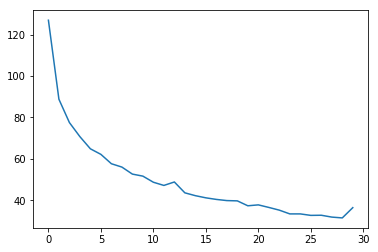

In [49]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


plt.plot(all_losses)
# plit.plot(all_accuracy)